In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


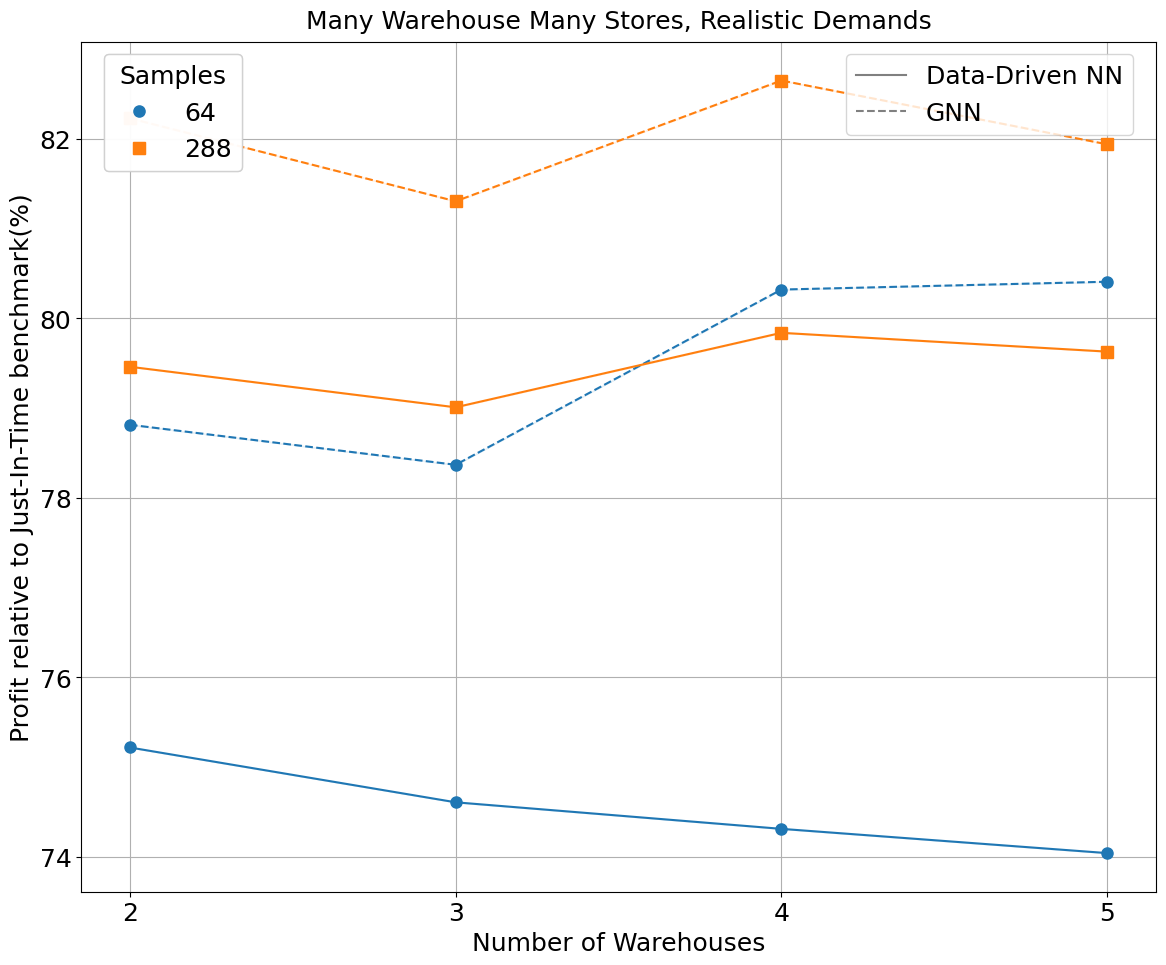

In [4]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    64: "#1f77b4",     # Blue
    288: "#ff7f0e",    # Orange
}

marker_scheme = {
    64: "o",           # Circle
    288: "s",          # Square
}

linestyle_scheme = {
    "Data-Driven NN": "-",      # Solid
    "GNN": "--",               # Dashed
}

# Define paths for each architecture
architectures = {
    "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

# Define configs for different settings
configs = [
    "n_warehouse_21_2_real_lost_demand",
    "n_warehouse_21_3_real_lost_demand",
    "n_warehouse_21_4_real_lost_demand",
    "n_warehouse_21_5_real_lost_demand"
]

# Map configs to their warehouses values for plotting
config_to_warehouses = {
    "n_warehouse_21_2_real_lost_demand": 2,
    "n_warehouse_21_3_real_lost_demand": 3,
    "n_warehouse_21_4_real_lost_demand": 4,
    "n_warehouse_21_5_real_lost_demand": 5
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [64, 288]

dfs = []
jit_dfs = []

# Create dataframes for each architecture, config and sample size
for arch_name, path in architectures.items():
    for config in configs:
        if arch_name == "Just-In-Time":
            # For Just-In-Time, create dataframes for each sample size
            for sample_size in sample_sizes:
                jit_df = results_interpretor.make_table({1: path},
                    {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
                if not jit_df.empty:
                    jit_df.insert(2, 'Architecture Class', arch_name)
                    jit_df.insert(1, 'hyperparam_name', arch_name)
                    jit_df['config'] = config
                    jit_df['n_warehouses'] = config_to_warehouses[config]
                    jit_df['train_dev_sample_and_batch_size'] = sample_size
                    jit_dfs.append(jit_df)
        else:
            # For other architectures, create dataframes for each sample size
            for sample_size in sample_sizes:
                
                if arch_name == "GNN Bottleneck" and sample_size == 64:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                        'config': [config],
                        'test_n_samples': [sample_size],
                        "train_batch_size": [72]},
                        default_condition_setter, custom_data_filler,
                        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
                else:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                        'config': [config],
                        'test_n_samples': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['config'] = config
                df['n_warehouses'] = config_to_warehouses[config]
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

# Find Just-In-Time loss for each config and sample size
jit_losses = {}
for config in configs:
    for sample_size in sample_sizes:
        jit_data = jit_df[(jit_df['config'] == config) & 
                          (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
        if not jit_data.empty:
            jit_loss = jit_data['Test Loss'].min()
            jit_losses[(config, sample_size)] = jit_loss

# Calculate loss ratio compared to Just-In-Time
stats_by_arch_sample_and_config = {}
for config in configs:
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty:
        continue
    
    for sample_size in sample_sizes:
        if (config, sample_size) not in jit_losses:
            continue
            
        jit_loss = jit_losses[(config, sample_size)]
        
        sample_data = config_data[config_data['train_dev_sample_and_batch_size'] == sample_size].copy()
        if sample_data.empty:
            continue
            
        sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
        
        for arch in sample_data['Architecture Class'].unique():
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_config:
                stats_by_arch_sample_and_config[key] = []
                
            arch_data = sample_data[sample_data['Architecture Class'] == arch]
            if not arch_data.empty:
                ratios = arch_data['Loss Ratio'].to_numpy()
                # Convert ratio to percentage (ratio - 1) * 100
                mean_percentage = np.mean(ratios * 100)
                std_percentage = np.std(ratios * 100)
                ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                stats_by_arch_sample_and_config[key].append({
                    'config': config,
                    'n_warehouses': config_to_warehouses[config],
                    'mean_percentage': mean_percentage,
                    'ci_lower': mean_percentage - ci_95,
                    'ci_upper': mean_percentage + ci_95
                })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of warehouses for proper x-axis ordering
        stats_df = stats_df.sort_values('n_warehouses')
        
        # Convert pandas series to numpy arrays before plotting
        n_warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_percentage_array = stats_df['mean_percentage'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_warehouses_array, mean_percentage_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-In-Time benchmark(%)', fontsize=FONTSIZE)
plt.grid(True)

# Set x-ticks to show only number of warehouses
x_ticks = sorted(list(config_to_warehouses.values()))
plt.xticks(x_ticks, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.title('Many Warehouse Many Stores, Realistic Demands', fontsize=FONTSIZE, pad=10)

plt.tight_layout()
plt.show()

In [3]:
print(df.to_string())

    # of stores hyperparam_name  train_dev_sample_and_batch_size Architecture Class                             config  test_n_samples  Learning Rate  Train Loss    Dev Loss   Test Loss  # of runs                                                                                                                                                                                                                                                                                 path  n_warehouses
0             1  Data-Driven NN                               64     Data-Driven NN  n_warehouse_21_2_real_lost_demand              64         0.0001 -558.224872 -505.653274 -445.450184         26  /user/ml4723/Prj/NIC/ray_results/finals_real_n_warehouses_n_stores/data_driven_net_n_warehouses_real/run_2025-05-14_12-44-15/run_ac46a_00080_80_config=n_warehouse_21_2_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0001,master_n_warehouses=51_2025-05-14_12-44-17             2
1             1  Data-Dr

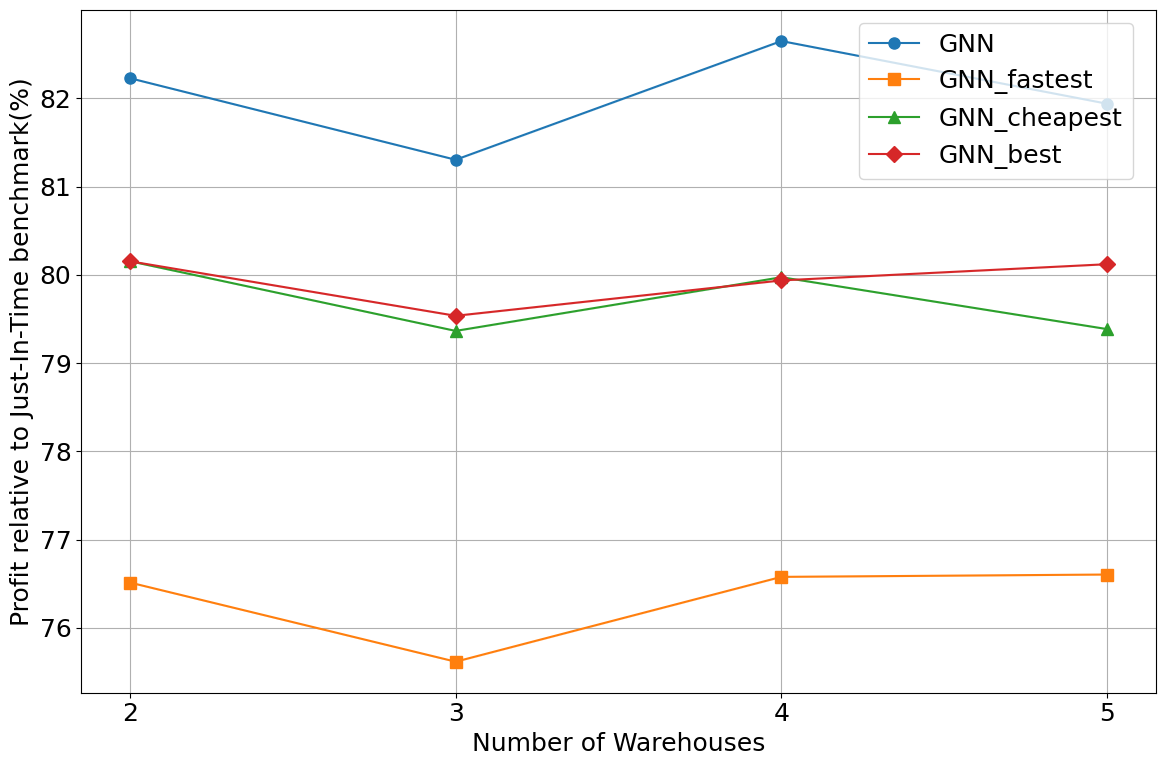

In [5]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_real_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",          # Blue
    "GNN_fastest": "#ff7f0e",  # Orange
    "GNN_cheapest": "#2ca02c", # Green
    "GNN_best": "#d62728",     # Red
}

marker_scheme = {
    "GNN": "o",                # Circle
    "GNN_fastest": "s",        # Square
    "GNN_cheapest": "^",       # Triangle
    "GNN_best": "D",           # Diamond
}

# Define paths for each architecture
architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
    "GNN_fastest": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_fastest',
    "GNN_cheapest": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_cheapest',
    "GNN_best": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_best',
    "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
}

# Define configs for different settings
configs = [
    "n_warehouse_21_2_real_lost_demand",
    "n_warehouse_21_3_real_lost_demand",
    "n_warehouse_21_4_real_lost_demand",
    "n_warehouse_21_5_real_lost_demand"
]

# Map configs to their warehouses values for plotting
config_to_warehouses = {
    "n_warehouse_21_2_real_lost_demand": 2,
    "n_warehouse_21_3_real_lost_demand": 3,
    "n_warehouse_21_4_real_lost_demand": 4,
    "n_warehouse_21_5_real_lost_demand": 5
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_size = 288

dfs = []
jit_dfs = []

# Create dataframes for each architecture and config
for arch_name, path in architectures.items():
    for config in configs:
        if arch_name == "Just-In-Time":
            # For Just-In-Time benchmark
            jit_df = results_interpretor.make_table({1: path},
                {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if not jit_df.empty:
                jit_df.insert(2, 'Architecture Class', arch_name)
                jit_df.insert(1, 'hyperparam_name', arch_name)
                jit_df['config'] = config
                jit_df['n_warehouses'] = config_to_warehouses[config]
                jit_dfs.append(jit_df)
        else:
            # For other architectures
            if arch_name == "GNN_best":
                config_read = config + "_best"
            else:
                config_read = config
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'config': [config_read]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['config'] = config
            df['n_warehouses'] = config_to_warehouses[config]
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)
jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()

# Find Just-In-Time loss for each config
jit_losses = {}
for config in configs:
    jit_data = jit_df[jit_df['config'] == config]
    if not jit_data.empty:
        jit_loss = jit_data['Test Loss'].min()
        jit_losses[config] = jit_loss

# Calculate loss ratio compared to Just-In-Time
stats_by_arch_and_config = {}
for config in configs:
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty or config not in jit_losses:
        continue
    
    jit_loss = jit_losses[config]
    config_data.loc[:, 'Loss Ratio'] = config_data['Test Loss'] / jit_loss
    
    for arch in config_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_config:
            stats_by_arch_and_config[key] = []
            
        arch_data = config_data[config_data['Architecture Class'] == arch]
        if not arch_data.empty:
            ratios = arch_data['Loss Ratio'].to_numpy()
            # Convert ratio to percentage (ratio - 1) * 100
            mean_percentage = np.mean(ratios * 100)
            std_percentage = np.std(ratios * 100)
            ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
            stats_by_arch_and_config[key].append({
                'config': config,
                'n_warehouses': config_to_warehouses[config],
                'mean_percentage': mean_percentage,
                'ci_lower': mean_percentage - ci_95,
                'ci_upper': mean_percentage + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Sort by number of warehouses for proper x-axis ordering
        stats_df = stats_df.sort_values('n_warehouses')
        
        # Convert pandas series to numpy arrays before plotting
        n_warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_percentage_array = stats_df['mean_percentage'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_warehouses_array, mean_percentage_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

# Create legend entries for architectures
arch_patches = [plt.Line2D([0], [0], color=color_scheme[arch], marker=marker_scheme[arch], 
                          linestyle='-', label=arch, markersize=8)
               for arch in color_scheme.keys()]

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-In-Time benchmark(%)', fontsize=FONTSIZE)
plt.grid(True)

# Set x-ticks to show only number of warehouses
x_ticks = sorted(list(config_to_warehouses.values()))
plt.xticks(x_ticks, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Create legend
plt.legend(handles=arch_patches, 
          bbox_to_anchor=(0.99, 1),
          loc='upper right', 
          fontsize=FONTSIZE)

plt.tight_layout()
plt.show()

In [6]:
print(df.to_string())

    # of stores hyperparam_name  train_dev_sample_and_batch_size Architecture Class                             config  Learning Rate  Train Loss    Dev Loss   Test Loss  # of runs                                                                                                                                                                                                                                                                 path  n_warehouses
0             1             GNN                              288                GNN  n_warehouse_21_2_real_lost_demand         0.0010 -611.754805 -585.043588 -534.281305          9  /user/ml4723/Prj/NIC/ray_results/finals_real_n_warehouses_n_stores/GNN_real_selfloop/run_2025-05-16_12-58-41/run_04c58_00004_4_config=n_warehouse_21_2_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0010,n_MP=2,repeats=1,stop_i_2025-05-16_12-58-41             2
1             1             GNN                              288                GNN  n_w